In [1]:
%pylab inline
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from tools.flux_calculator import calc_fluxes, make_rotation_diagram
from tools.flux_calculator.helpers import extract_hitran_data, extract_vup, strip_superfluous_hitran_data, \
                                          line_fit, fwhm_to_sigma, calc_linewidth
from tools.spec_utils import vgeo, vproj, vlsr_to_vhelio

hdulist20110620=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20110620_glue.fits')
hdulist20120512=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20120512_glue.fits')
hdulist20120701=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20120701_glue.fits')
hdulist20130624=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20130624_glue.fits')

data20110620=hdulist20110620[1].data
data20120512=hdulist20120512[1].data
data20120701=hdulist20120701[1].data
data20130624=hdulist20130624[1].data

Populating the interactive namespace from numpy and matplotlib


# Doppler Shift Correction

In [2]:
#######################################################################

# VGEO Doppler Shift variables

mycoord=SkyCoord('16h11m31.35s', '-18d38m25.96s', frame='icrs')
mydate20110620=Time('2011-06-20T00:00:00.0', format='isot', scale='utc')
mydate20120512=Time('2012-05-12T00:00:00.0', format='isot', scale='utc')
mydate20120701=Time('2012-07-01T00:00:00.0', format='isot', scale='utc')
mydate20130624=Time('2013-06-24T00:00:00.0', format='isot', scale='utc')
vhelio = vlsr_to_vhelio(mycoord, 4.29) #VLSR of 4.5 km/s according to Salyk et al. 2014

#VGEO Doppler Shift Correction

#data20110620['wave'] += waveShift(-vgeo(mydate20110620,mycoord,vhel=vhelio), data20110620['wave'])
#data20120512[1]['wave'] += waveShift(-vgeo(mydate20120512,mycoord,vhel=vhelio), data0120512['wave'])
#data20120701[1].data['wave'] += waveShift(-vgeo(mydate20120701,mycoord,vhel=vhelio), data20120701['wave'])
#data20130624['wave'] += waveShift(-vgeo(mydate20130624,mycoord,vhel=vhelio), data20130624['wave'])

#######################################################################

# Hand-Picked Shifts

vdop20110620 = 11 #km/s
vdop20120512 = -10 #km/s
vdop20120701 = -24 #km/s
vdop20130624 = -23.5 #km/s

def waveShift(vdop, wave):
    return vdop*1e9*wave/(const.c.to('micron/s').value)

data20110620['wave'] += waveShift(vdop20110620, data20110620['wave'])
data20120512['wave'] += waveShift(vdop20120512, data20120512['wave'])
data20120701['wave'] += waveShift(vdop20120701, data20120701['wave'])
data20130624['wave'] += waveShift(vdop20130624, data20130624['wave'])


# Extracting Hitran Data

In [3]:
#######################################################################

# Creating hitran data tables

out_all12 = extract_hitran_data('CO', 4.648, 5.018)
out_all13 = extract_hitran_data('CO', 4.648, 5.018, isotopologue_number=2)
hitran12CO1_0 = extract_vup(out_all12,1)
hitran12CO2_1 = extract_vup(out_all12,2)

#######################################################################

# Removing unusable emission lines

del hitran12CO1_0[5:]
del hitran12CO1_0[:2]
del hitran12CO2_1[27:34]
del hitran12CO2_1[4:27]

# Lineprofiles

## 2012/05/12 shifted +1.5, 2012/07/01 shifted +3, 2013/06/24 shifted +4.5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


array([4.64716451, 4.64723363, 4.64730277, ..., 5.0333718 , 5.03345235,
       5.03353291])

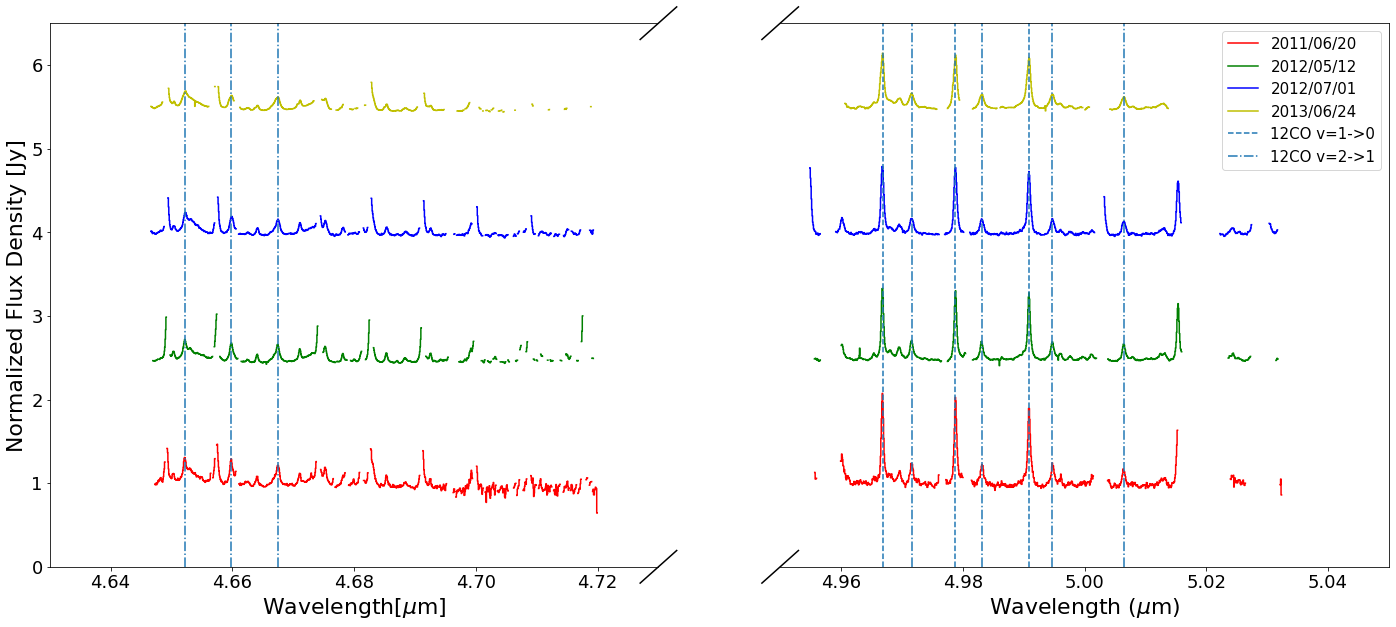

In [31]:
#######################################################################

# Preparing plot

fig=plt.figure(figsize=(24,10))
ax=fig.add_subplot(111)
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

#######################################################################

# Plotting data

ax1.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r')
ax1.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g')
ax1.plot(data20120701['wave'], data20120701['div']+3, drawstyle='steps-mid', color='b')
ax1.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y')

ax2.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r', label='2011/06/20')
ax2.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g', label='2012/05/12')
ax2.plot(data20120701['wave'], data20120701['div']+3, drawstyle='steps-mid', color='b', label='2012/07/01')
ax2.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y', label='2013/06/24')

#######################################################################

# Plotting CO Emission Lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    if(wave<4.8):
        ax1.axvline(wave, 0,30, linestyle='--')
    else:
        ax2.axvline(wave, 0,30, linestyle='--')
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if(wave<4.8):
        ax1.axvline(wave, 0,30, linestyle='-.')
        #ax1.text(wave-0.001, 8, i)
    else:
        ax2.axvline(wave, 0,30, linestyle='-.')
        #ax2.text(wave-0.001, 8, i)
        
# Labeling Emission Lines
        
ax2.axvline(0,0,0, linestyle='--', label='12CO v=1->0')
ax2.axvline(0,0,0, linestyle='-.', label='12CO v=2->1')
    
#######################################################################

# Configuration of split x axis

# Tick marks signifying broken axis
g = .03
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-g,1+g), (-g,+g), **kwargs)
ax1.plot((1-g,1+g),(1-g,1+g), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-g,+g), (1-g,1+g), **kwargs)
ax2.plot((-g,+g), (-g,+g), **kwargs)

# Hiding axes and values on those axes
ax2.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.yaxis.set_visible(False)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.axis('off')

#######################################################################

# Plot Formatting
#ax.set_title('Telluric-Corrected AS 205 Spectra \n', fontsize=20)
ax1.set_xlabel('Wavelength[$\mu$m]', fontsize=22)
ax2.set_xlabel('Wavelength ($\mu$m)', fontsize=22)
ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=22)
ax2.legend(loc=1, prop={'size': 15})
ax1.set_xlim(4.63, 4.73)
ax2.set_xlim(4.95, 5.05)
ax1.set_ylim(0,6.5)
ax2.set_ylim(0,6.5)

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

#fig.savefig('./Plots/Telluric-Corrected_AS205_Spectra.eps')

data20110620['wave']


# Lineprofile Graphing Function

In [5]:
def graph_emission_line(hitranData, observations, dates, src, fitLines=True, km=False):
    
    fig=plt.figure(figsize(10,5))
    ax=fig.add_subplot(111)
    
    def waveToKM(myLambda, DLambda):
        vel = DLambda*const.c.to('km/s').value/ myLambda
        return vel
    
#######################################################################

    # For each date of observations, graph emission line
    for i in arange(dates.size):
        myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
        wave=observations[i]['wave'][myBool]
        div=observations[i]['div'][myBool]
        k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])
        
#######################################################################

        # Plotting with x-axis in km/s
        if km:
            ax.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
            ax.set_xlabel('km/s', fontsize=12)
            axvline(0, 0,2, linestyle='--')
            
#######################################################################

            # fitLines will plot a line fit, and illustrate FWHM on emission line profile
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(k_m, fit['yfit'], label=dates[i]+' Fit')
                waveMax = k_m[np.argmax(fit['yfit'])]
                (fwhm, fwhm_err) = calc_linewidth(fit['parameters'], fit['parameter_errors'])
                x=arange(waveMax-fwhm.value/2, waveMax+fwhm.value/2, 0.1)
                ax.plot(x, np.full(x.size, np.max(fit['yfit'])-(np.max(fit['yfit'])-fit['parameters'][3])/2), label=dates[i]+' FWHM')
                
#######################################################################

        # Plotting with wavelength on x-axis
        else:
            ax.plot(wave,div,drawstyle='steps-mid', label=dates[i])
            ax.set_xlim(hitranData['wave']-0.001, hitranData['wave']+0.001)
            ax.set_xlabel('Wavelength [$\mu$m]', fontsize=12)
            axvline(hitranData['wave'], 0, 2, linestyle='--')
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(wave, fit['yfit'], label=dates[i]+' Fit')
                
#######################################################################
        
    # Plotting hitran emisssion line
    ax.axvline(0,0,0,linestyle='--', label=hitranData['Qpp'])
    
    if(hitranData['local_iso_id']==1):
        isotope = '12CO'
    elif(hitranData['local_iso_id']==2):
        isotope = '13CO'
        
    if(np.int(hitranData['Vp'])==1):
        trans= 'v=1-0'
    elif(np.int(hitranData['Vp'])==2):
        trans= 'v=2-1'
        
    pNum = hitranData['Qpp']
    title = 'Lineprofile for '+isotope+' '+trans+pNum+' Emission line from '+src
    
    # Setting title and axes labels
    ax.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    ax.legend(loc=1, prop={'size':12})
    
    

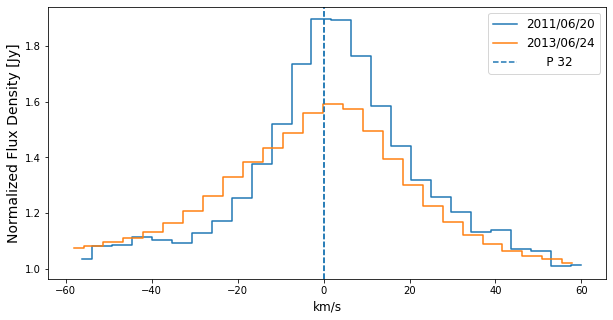

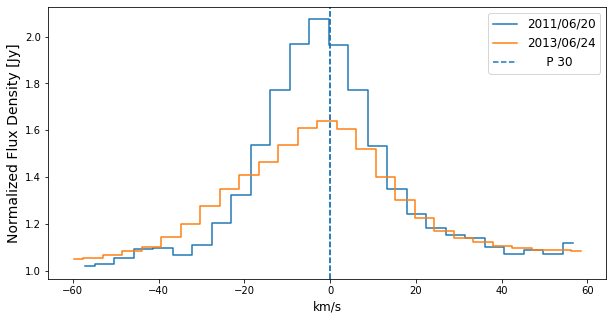

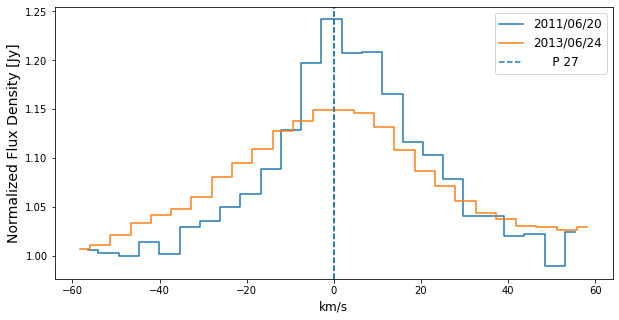

In [6]:
observations = np.array([data20110620, data20130624])
dates = np.array(['2011/06/20', '2013/06/24'])

graph_emission_line(hitran12CO1_0[0], observations, dates,'AS205', km=True, fitLines=False)
graph_emission_line(hitran12CO1_0[2], observations, dates,'AS205', km=True, fitLines=False)
graph_emission_line(hitran12CO2_1[1], observations, dates,'AS205', km=True, fitLines=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

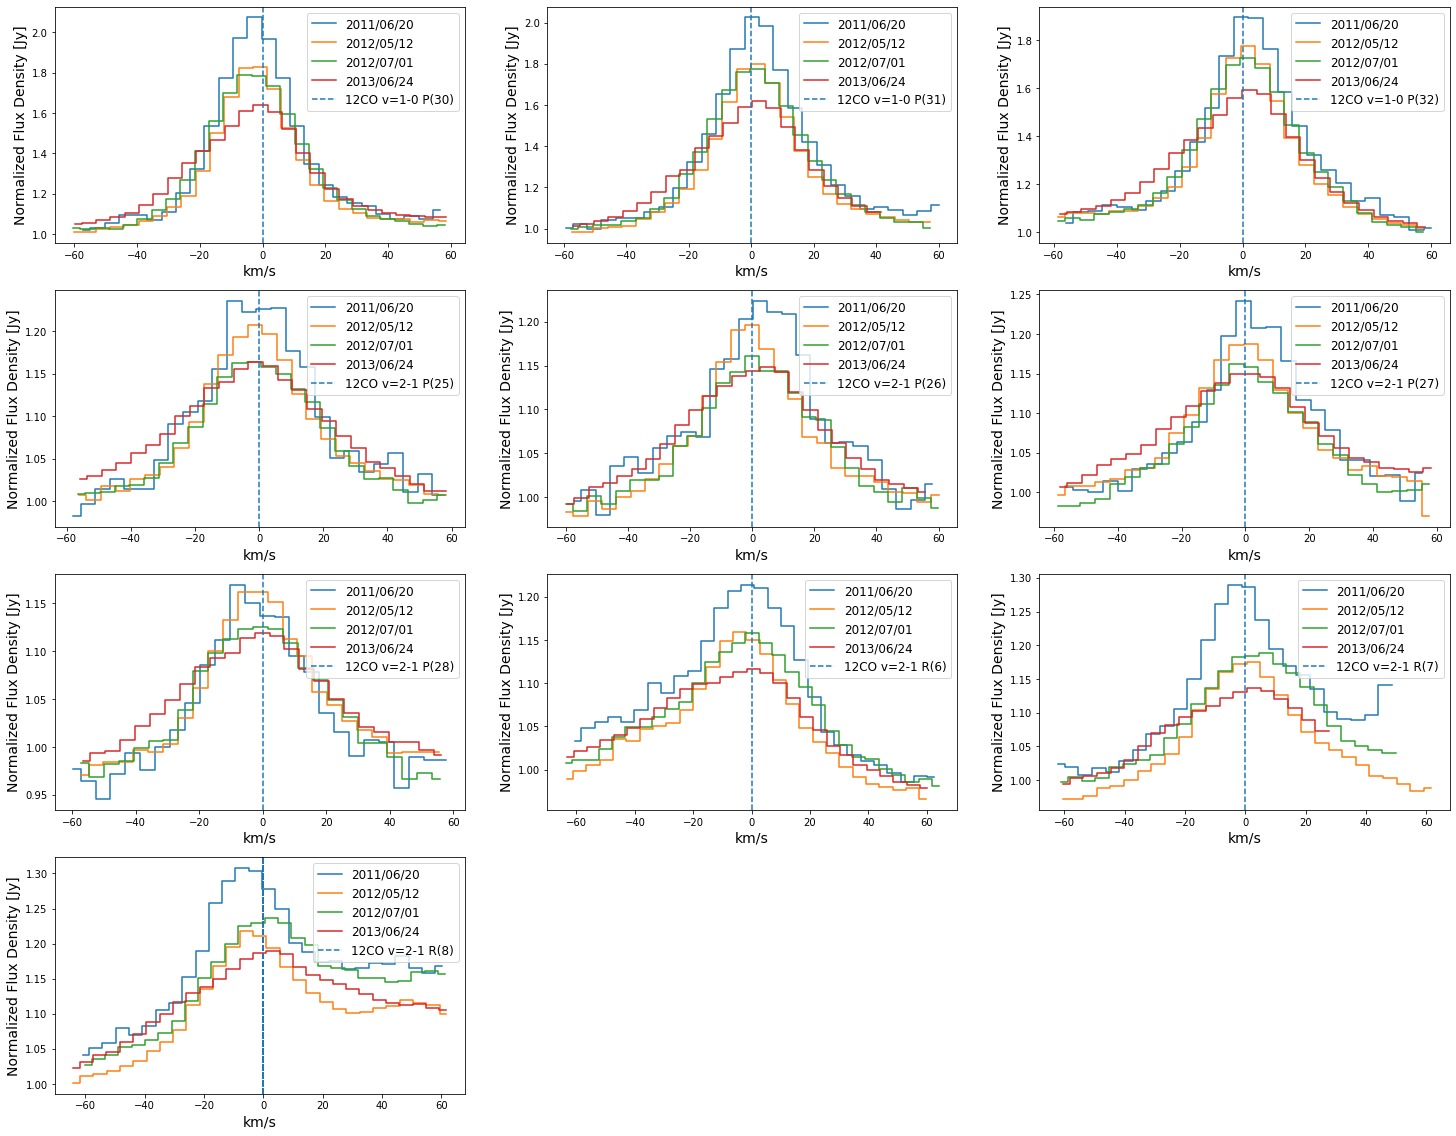

In [26]:
def waveToKM(myLambda, DLambda):
    vel = DLambda*const.c.to('km/s').value/ myLambda
    return vel

fig=plt.figure(figsize(25,20))
ax=fig.add_subplot(431)
ax1=fig.add_subplot(432)
ax2=fig.add_subplot(433)
ax3=fig.add_subplot(434)
ax4=fig.add_subplot(435)
ax5=fig.add_subplot(436)
ax6=fig.add_subplot(437)
ax7=fig.add_subplot(438)
ax8=fig.add_subplot(439)
ax9=fig.add_subplot(4, 3, 10)

observations = np.array([data20110620, data20120512, data20120701, data20130624])
dates = np.array(['2011/06/20', '2012/05/12', '2012/07/01', '2013/06/24'])

#######################################################################

hitranData=hitran12CO1_0[2]

for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax.axvline(0,0,2,linestyle='--', label='12CO v=1-0 P(30)')
ax.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO1_0[1]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax1.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax1.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax1.axvline(0,0,2,linestyle='--', label='12CO v=1-0 P(31)')
ax1.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO1_0[0]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax2.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax2.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax2.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax2.axvline(0,0,2,linestyle='--', label='12CO v=1-0 P(32)')
ax2.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[3]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax3.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax3.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax3.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax3.axvline(0,0,2,linestyle='--', label='12CO v=2-1 P(25)')
ax3.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[2]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax4.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax4.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax4.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax4.axvline(0,0,2,linestyle='--', label='12CO v=2-1 P(26)')
ax4.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[1]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax5.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax5.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax5.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax5.axvline(0,0,2,linestyle='--', label='12CO v=2-1 P(27)')
ax5.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[0]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax6.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax6.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax6.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax6.axvline(0,0,2,linestyle='--', label='12CO v=2-1 P(28)')
ax6.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[4]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax7.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax7.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax7.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax7.axvline(0,0,2,linestyle='--', label='12CO v=2-1 R(6)')
ax7.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[5]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax8.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax8.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax8.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax8.axvline(0,0,2,linestyle='--', label='12CO v=2-1 R(7)')
ax8.legend(loc=1, prop={'size':12})

#######################################################################

hitranData=hitran12CO2_1[6]
    
for i in arange(dates.size):
    myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
    wave=observations[i]['wave'][myBool]
    div=observations[i]['div'][myBool]
    k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])

    ax9.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
    ax9.set_xlabel('km/s', fontsize=14)
    axvline(0, 0,2, linestyle='--')
    pNum = hitranData['Qpp']
    
    # Setting title and axes labels
    ax9.set_ylabel('Normalized Flux Density [Jy]', fontsize=14)
    
    
# Plotting hitran emisssion line
ax9.axvline(0,0,2,linestyle='--', label='12CO v=2-1 R(8)')
ax9.legend(loc=1, prop={'size':12})


fig.savefig('./Plots/lineprofiles.eps')




# flux_calculator

In [8]:
t1=calc_fluxes(data20110620['wave'],data20110620['div'],hitran12CO1_0)
t2=calc_fluxes(data20120512['wave'],data20120512['div'],hitran12CO1_0)
t3=calc_fluxes(data20120701['wave'],data20120701['div'],hitran12CO1_0)
t4=calc_fluxes(data20130624['wave'],data20130624['div'],hitran12CO1_0)

t5=calc_fluxes(data20110620['wave'],data20110620['div'],hitran12CO2_1)
t6=calc_fluxes(data20120512['wave'],data20120512['div'],hitran12CO2_1)
t7=calc_fluxes(data20120701['wave'],data20120701['div'],hitran12CO2_1)
t8=calc_fluxes(data20130624['wave'],data20130624['div'],hitran12CO2_1)

# Linefluxes 
## 2011/06 shifted -0.0009, 2012/05 shifted -0.0003, 2012/07 shifted +0.0003, 2013/06 shifted +0.0009

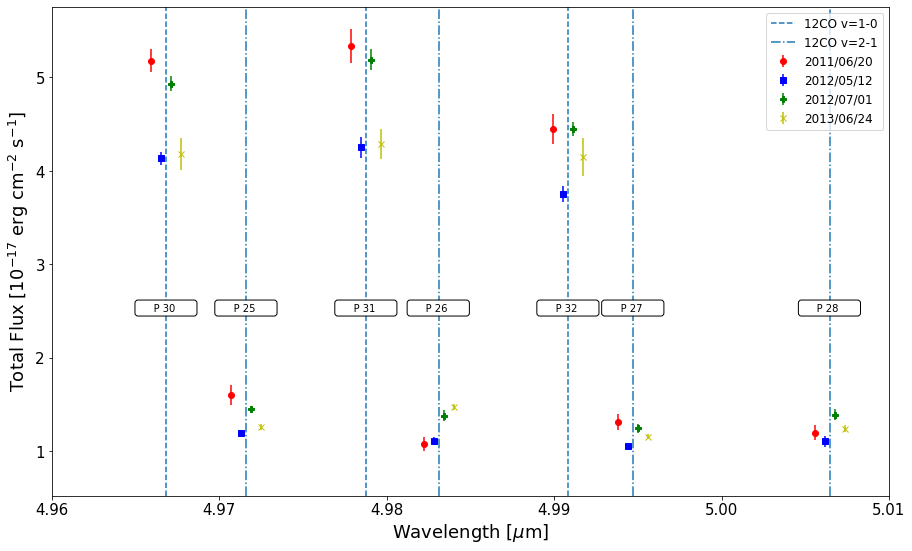

In [9]:
#######################################################################

# Configuring Plot

fig=plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111)

#######################################################################

# Configuring text box

props = dict(boxstyle='round', facecolor='white', alpha=1)

# Drawing and labeling CO emission lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    ax1.axvline(wave, 0, 30, linestyle='--')
    ax1.text(wave-0.0017, 2.5, hitran12CO1_0['Qpp'][i], bbox=props)
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if (wave>4.9):
        ax1.axvline(wave, 0, 30, linestyle='-.')
        ax1.text(wave-0.0017, 2.5, hitran12CO2_1['Qpp'][i],bbox=props)
        
# Labeling Hitran Data
        
ax1.axvline(0,0,0, linestyle='--', label='12CO v=1-0')
ax1.axvline(0,0,0, linestyle='-.', label='12CO v=2-1')

#######################################################################

# Plotting Linefluxes and error bars for each date

errorbar(t1['wave']-0.0009, t1['lineflux']*1e17, yerr=t1['lineflux_err']*1e17, fmt='ro', label='2011/06/20')
errorbar(t2['wave']-0.0003, t2['lineflux']*1e17, yerr=t2['lineflux_err']*1e17, fmt='bs', label='2012/05/12')
errorbar(t3['wave']+0.0003, t3['lineflux']*1e17, yerr=t3['lineflux_err']*1e17, fmt='gP', label='2012/07/01')
errorbar(t4['wave']+0.0009, t4['lineflux']*1e17, yerr=t4['lineflux_err']*1e17, fmt='yx', label='2013/06/24')
errorbar(t5['wave']-0.0009, t5['lineflux']*1e17, yerr=t5['lineflux_err']*1e17, fmt='ro')
errorbar(t6['wave']-0.0003, t6['lineflux']*1e17, yerr=t6['lineflux_err']*1e17, fmt='bs')
errorbar(t7['wave']+0.0003, t7['lineflux']*1e17, yerr=t7['lineflux_err']*1e17, fmt='gP')
errorbar(t8['wave']+0.0009, t8['lineflux']*1e17, yerr=t8['lineflux_err']*1e17, fmt='yx')

#######################################################################

# Plot Formatting

ax1.set_ylabel('Total Flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$]', fontsize=18)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
ax1.set_xlim(4.96, 5.01)
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax1.legend(loc=1, prop={'size': 12})

In all of these higher energy emission lines, with P 26 and P 28 12CO v=2-1 lines, 2011/06/20 lines had the highest total flux, then 2012/07/01 data, then 2012/05/12 data, and finally 2013/06/24 data with lowest total flux.

# Linewidths
## 2011/06 shifted -0.0009, 2012/05 shifted -0.0003, 2012/07 shifted +0.0003, 2013/06 shifted +0.0009

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


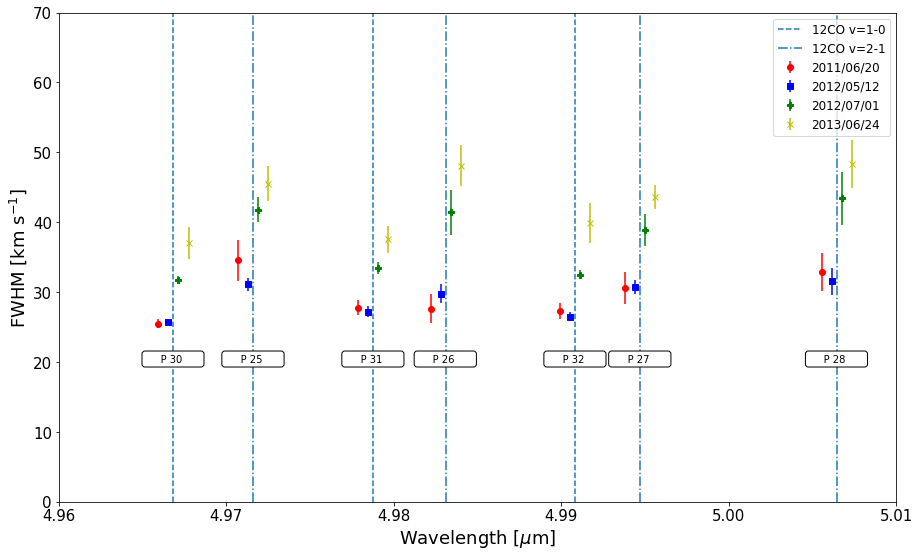

In [32]:
#######################################################################

# Configuring Plot

fig=plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111)

#######################################################################

# Configuring text box

props = dict(boxstyle='round', facecolor='white', alpha=1)

# Drawing and labeling CO emission lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    ax1.axvline(wave, 0, 30, linestyle='--')
    ax1.text(wave-0.0017, 20, hitran12CO1_0['Qpp'][i], bbox=props)
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if (wave>4.9):
        ax1.axvline(wave, 0, 30, linestyle='-.')
        ax1.text(wave-0.0017, 20, hitran12CO2_1['Qpp'][i],bbox=props)
        
# Labeling Hitran Data
        
ax1.axvline(0,0,0, linestyle='--', label='12CO v=1-0')
ax1.axvline(0,0,0, linestyle='-.', label='12CO v=2-1')

#######################################################################

# Plotting Linefluxes and error bars for each date

errorbar(t1['wave']-0.0009, t1['linewidth'], yerr=t1['linewidth_err'], fmt='ro', label='2011/06/20')
errorbar(t2['wave']-0.0003, t2['linewidth'], yerr=t2['linewidth_err'], fmt='bs', label='2012/05/12')
errorbar(t3['wave']+0.0003, t3['linewidth'], yerr=t3['linewidth_err'], fmt='gP', label='2012/07/01')
errorbar(t4['wave']+0.0009, t4['linewidth'], yerr=t4['linewidth_err'], fmt='yx', label='2013/06/24')
errorbar(t5['wave']-0.0009, t5['linewidth'], yerr=t5['linewidth_err'], fmt='ro')
errorbar(t6['wave']-0.0003, t6['linewidth'], yerr=t6['linewidth_err'], fmt='bs')
errorbar(t7['wave']+0.0003, t7['linewidth'], yerr=t7['linewidth_err'], fmt='gP')
errorbar(t8['wave']+0.0009, t8['linewidth'], yerr=t8['linewidth_err'], fmt='yx')

#######################################################################

# Plot Formatting

ax1.set_ylabel('FWHM [km s$^{-1}$]', fontsize=18)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
ax1.set_ylim(0,70)
ax1.legend(loc=1, prop={'size': 12})
ax1.set_xlim(4.96, 5.01)

ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )

fig.savefig("./Plots/FWHM.eps")

# Rotation Diagram

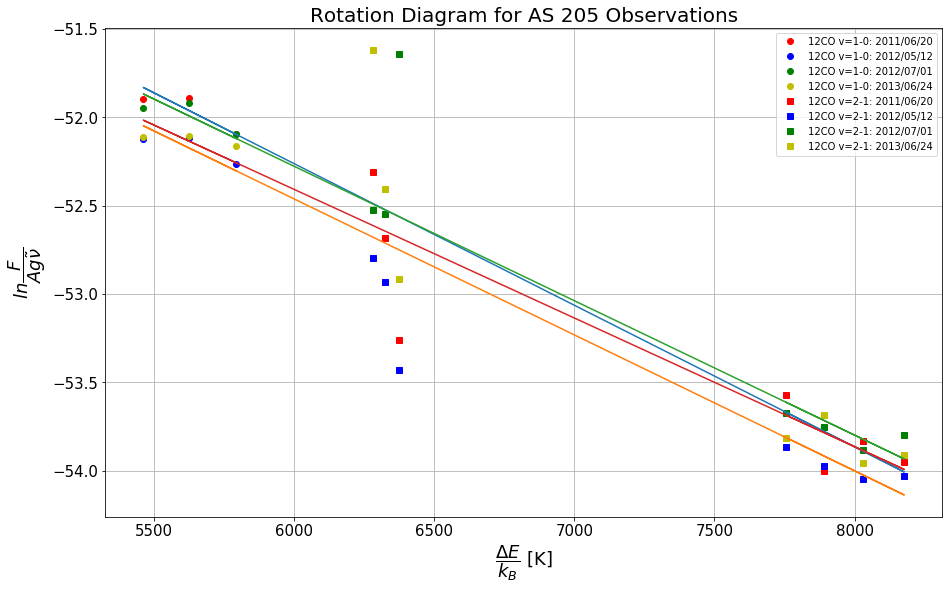

In [15]:
#######################################################################

# defining rotation diagram

graph1 = make_rotation_diagram(t1)
graph2 = make_rotation_diagram(t2)
graph3 = make_rotation_diagram(t3)
graph4 = make_rotation_diagram(t4)
graph5 = make_rotation_diagram(t5)
graph6 = make_rotation_diagram(t6)
graph7 = make_rotation_diagram(t7)
graph8 = make_rotation_diagram(t8)

#######################################################################

# Preparing plot

fig=plt.figure(figsize=(15,9))
ax1=fig.add_subplot(111)

# Plotting data

ax1.plot(graph1['x'], graph1['y'], 'ro', label='12CO v=1-0: 2011/06/20')
ax1.plot(graph2['x'], graph2['y'], 'bo', label='12CO v=1-0: 2012/05/12')
ax1.plot(graph3['x'], graph3['y'], 'go', label='12CO v=1-0: 2012/07/01')
ax1.plot(graph4['x'], graph4['y'], 'yo', label='12CO v=1-0: 2013/06/24')
ax1.plot(graph5['x'], graph5['y'], 'rs', label='12CO v=2-1: 2011/06/20')
ax1.plot(graph6['x'], graph6['y'], 'bs', label='12CO v=2-1: 2012/05/12')
ax1.plot(graph7['x'], graph7['y'], 'gs', label='12CO v=2-1: 2012/07/01')
ax1.plot(graph8['x'], graph8['y'], 'ys', label='12CO v=2-1: 2013/06/24')

# Configuring plot

ax1.set_title("Rotation Diagram for AS 205 Observations", fontsize=20)
ax1.set_ylabel('$ln\\dfrac{F}{Ag\~\\nu}$', fontsize=18)
ax1.set_xlabel('$\\dfrac{\Delta E}{k_B}$ [K]', fontsize=18)
ax1.legend(loc=1,prop={'size': 10})
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax1.grid()

aX = np.append(graph1['x'], graph5['x'][:4])
aY = np.append(graph1['y'], graph5['y'][:4])

bX = np.append(graph2['x'], graph6['x'][:4])
bY = np.append(graph2['y'], graph6['y'][:4])

cX = np.append(graph3['x'], graph7['x'][:4])
cY = np.append(graph3['y'], graph7['y'][:4])

dX = np.append(graph4['x'], graph8['x'][:4])
dY = np.append(graph4['y'], graph8['y'][:4])

m1, b1 = np.polyfit(aX, aY, 1)
m2, b2 = np.polyfit(bX, bY, 1)
m3, b3 = np.polyfit(cX, cY, 1)
m4, b4 = np.polyfit(dX, dY, 1)

ax1.plot(aX, m1*aX+b1)
ax1.plot(bX, m2*aX+b2)
ax1.plot(cX, m3*aX+b3)
ax1.plot(dX, m4*aX+b4)

# m1, b1 = np.polyfit(graph1['x'], graph1['y'], 1)
# m2, b2 = np.polyfit(graph2['x'], graph2['y'], 1)
# m3, b3 = np.polyfit(graph3['x'], graph3['y'], 1)
# m4, b4 = np.polyfit(graph4['x'], graph4['y'], 1)

# ax1.plot(graph1['x'], m1*graph1['x']+b1, color='r')
# ax1.plot(graph2['x'], m2*graph2['x']+b2, color='b')
# ax1.plot(graph3['x'], m3*graph3['x']+b3, color='g')
# ax1.plot(graph4['x'], m4*graph4['x']+b4, color='y')

# m5, b5 = np.polyfit(graph5['x'][:4], graph5['y'][:4], 1)
# m6, b6 = np.polyfit(graph6['x'][:4], graph6['y'][:4], 1)
# m7, b7 = np.polyfit(graph7['x'][:4], graph7['y'][:4], 1)
# m8, b8 = np.polyfit(graph8['x'][:4], graph8['y'][:4], 1)


# ax1.plot(graph5['x'][:4], m5*graph5['x'][:4]+b5, color='r')
# ax1.plot(graph6['x'][:4], m6*graph6['x'][:4]+b6, color='b')
# ax1.plot(graph7['x'][:4], m7*graph7['x'][:4]+b7, color='g')
# ax1.plot(graph8['x'][:4], m8*graph8['x'][:4]+b8, color='y')

#fig.savefig('./Plots/lineFit_RotationDiagram')


# Orbital Distances

Using Kepler's Third Law

$T^2 = \frac{4 \pi^2}{GM_{\star}}a^3$

$T = \frac{2\pi}{\omega}$, $\omega = \frac{(v/cos(i))^2}{a}$

$\frac{4\pi^2 a^2}{(v/cos(i))^2} = \frac{4\pi^2}{GM_{\star}}a^3$

$a = \frac{GM_{\star}cos^2(i)}{v^2}$

FWHM shows the gas's radial speed on either side of it's orbit due to doppler broadening, so dividing by 2 will yield the radial speed of the gas in orbit. I'll average from each of the dates the FWHM from the linewidths of viable 12CO v=1-0 and 12CO v=2-1 emission lines.

In [12]:
inclination = 15*pi/180 # inclination of 15 deg according to Salyk et al. 2014
mStar = 1 # best fit mass of AS205 N from Salyk et al. 2014

t1t5 = np.append(t1['linewidth'], t5['linewidth'])
t1t5_err = np.append(t1['linewidth_err'], t5['linewidth_err'])

t2t6 = np.append(t2['linewidth'], t6['linewidth'])
t2t6_err = np.append(t2['linewidth_err'], t6['linewidth_err'])

t3t7 = np.append(t3['linewidth'], t7['linewidth'])
t3t7_err = np.append(t3['linewidth_err'], t7['linewidth_err'])

t4t8 = np.append(t4['linewidth'], t8['linewidth'])
t4t8_err = np.append(t4['linewidth_err'], t8['linewidth_err'])

#######################################################################

# Finding averaged linewidths and error for each date

ave20110620 = np.mean(t1t5)
ave_err_20110620 = sqrt(np.sum(t1t5_err**2))/t1t5_err.size

ave20120512 = np.mean(t2t6)
ave_err_20120512 = sqrt(np.sum(t2t6_err**2))/t2t6_err.size

ave20120701 = np.mean(t3t7)
ave_err_20120701 = sqrt(np.sum(t3t7_err**2))/t3t7_err.size

ave20130624 = np.mean(t4t8)
ave_err_20130624 = sqrt(np.sum(t4t8_err**2))/t4t8_err.size

#######################################################################

def find_orbital_dist(speed):

    # mStar in solar masses
    # speed in km/s
    
    a = const.G.value*mStar*const.M_sun.value*cos(inclination)**2/(speed/2*1000)**2
    return a*u.m.to(u.AU)

def find_linewidth(dist):
    v = sqrt(const.G.value*mStar*const.M_sun.value*cos(inclination)**2/(1000**2*dist*u.AU.to(u.m)))
    return v*2

def find_orbital_dist_err(speed, speed_err):
    sigma = (2*const.G.value*mStar*const.M_sun.value*(cos(inclination)**3)/(((speed/2)*1000)**3))*(speed_err/2)
    return sigma*u.m.to(u.AU)

#######################################################################

dist20110620 = find_orbital_dist(ave20110620)
dist_err_20110620 = find_orbital_dist_err(ave20110620, ave_err_20110620)

dist20120512 = find_orbital_dist(ave20120512)
dist_err_20120512 = find_orbital_dist_err(ave20120512, ave_err_20120512)

dist20120701 = find_orbital_dist(ave20120701)
dist_err_20120701 = find_orbital_dist_err(ave20120701, ave_err_20120701)

dist20130624 = find_orbital_dist(ave20130624)
dist_err_20130624 = find_orbital_dist_err(ave20130624, ave_err_20130624)

print(dist20110620*u.AU, "+/-", dist_err_20110620*u.AU)
print(dist20120512*u.AU, "+/-", dist_err_20120512*u.AU)
print(dist20120701*u.AU, "+/-", dist_err_20120701*u.AU)
print(dist20130624*u.AU, "+/-", dist_err_20130624*u.AU)

3.4857951351341945 AU +/- 0.0002107744117118859 AU
3.6372908001199633 AU +/- 0.00014378929493091196 AU
1.7526219227714999 AU +/- 0.00023212993577120328 AU
1.3069815602849526 AU +/- 0.00012644929642690198 AU


/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


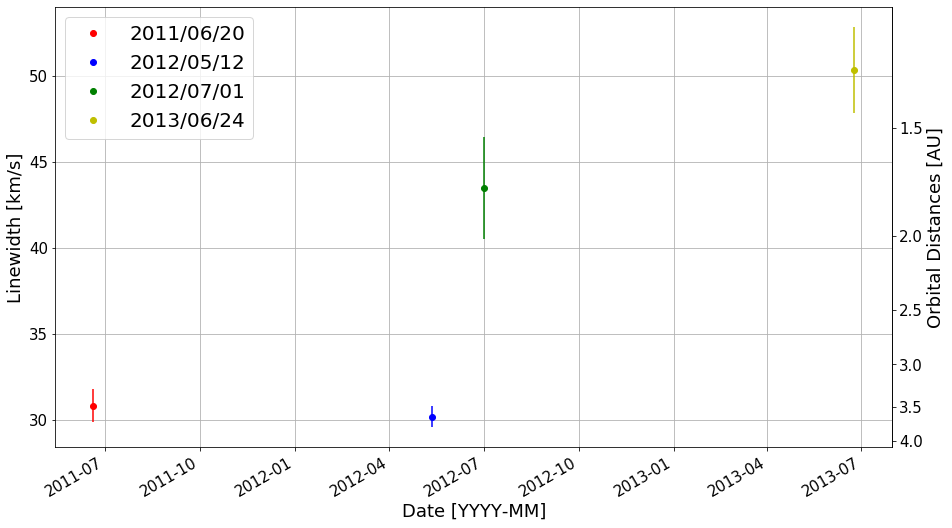

In [16]:
#######################################################################

fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111)
#ax1 = ax.twinx()

#######################################################################


ax.plot_date(mydate20110620.plot_date, ave20110620, color='r', label='2011/06/20')
ax.plot_date(mydate20120512.plot_date, ave20120512, color='b', label='2012/05/12')
ax.plot_date(mydate20120701.plot_date, ave20120701, color='g', label='2012/07/01')
ax.plot_date(mydate20130624.plot_date, ave20130624, color='y', label='2013/06/24')

errorbar(mydate20110620.plot_date, ave20110620, yerr=ave_err_20110620, color='r')
errorbar(mydate20120512.plot_date, ave20120512, yerr=ave_err_20120512, color='b')
errorbar(mydate20120701.plot_date, ave20120701, yerr=ave_err_20120701, color='g')
errorbar(mydate20130624.plot_date, ave20130624, yerr=ave_err_20130624, color='y')


#ax.errorbar(mydate20110620.plot_date, dist20110620.value, yerr=dist_err_20110620.value)
#ax.errorbar(mydate20120512.plot_date, dist20120512.value, yerr=dist_err_20120512.value)
#ax.errorbar(mydate20120701.plot_date, dist20120701.value, yerr=dist_err_20120701.value)
#ax.errorbar(mydate20130624.plot_date, dist20130624.value, yerr=dist_err_20130624.value)

secaxy = ax.secondary_yaxis('right', functions=(find_orbital_dist, find_linewidth))
secaxy.set_ylabel('Orbital Distances [AU]', fontsize=18)



#######################################################################

ax.set_xlabel('Date [YYYY-MM]', fontsize=18)
ax.set_ylabel('Linewidth [km/s]', fontsize=18)
ax.legend(prop={'size': 20})
ax.tick_params(axis='x', labelsize=15 )
ax.tick_params(axis='y', labelsize=15 )
secaxy.tick_params(axis='y', labelsize=15)
fig.autofmt_xdate()

ax.grid()

fig.savefig('./Plots/AS205orbit.eps')


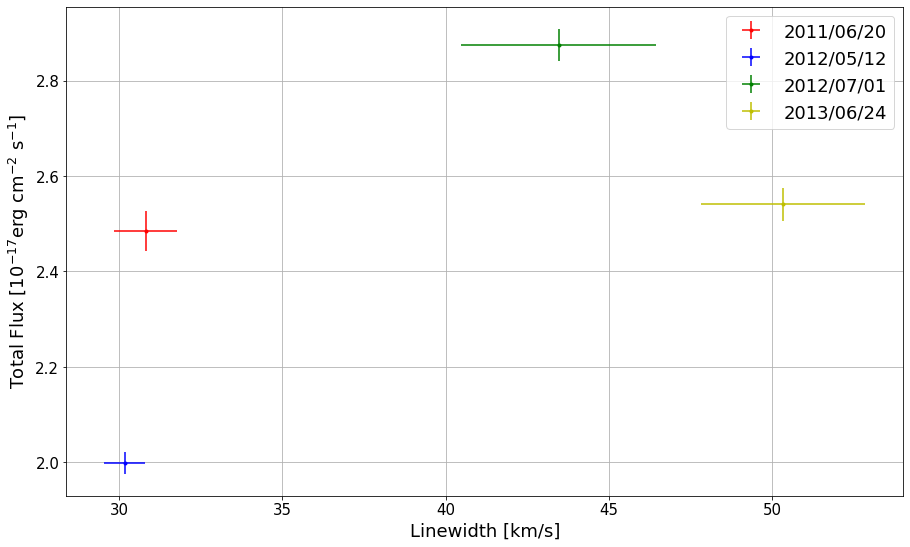

In [14]:
#######################################################################

fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111)

#######################################################################

flux_mean20110620 = np.mean(np.append(t1['lineflux'], t5['lineflux']))*1e17
flux_mean_err_20110620 = sqrt(np.sum(np.append(t1['lineflux_err'], t5['lineflux_err'])**2))/(t1['lineflux_err'].size+t5['lineflux_err'].size)

flux_mean20120512 = np.mean(np.append(t2['lineflux'], t6['lineflux']))*1e17
flux_mean_err_20120512 = sqrt(np.sum(np.append(t2['lineflux_err'], t6['lineflux_err'])**2))/(t2['lineflux_err'].size+t6['lineflux_err'].size)

flux_mean20120701 = np.mean(np.append(t3['lineflux'], t7['lineflux']))*1e17
flux_mean_err_20120701 = sqrt(np.sum(np.append(t3['lineflux_err'], t7['lineflux_err'])**2))/(t3['lineflux_err'].size+t7['lineflux_err'].size)

flux_mean20130624 = np.mean(np.append(t4['lineflux'], t8['lineflux']))*1e17
flux_mean_err_20130624 = sqrt(np.sum(np.append(t4['lineflux_err'], t8['lineflux_err'])**2))/(t4['lineflux_err'].size+t8['lineflux_err'].size)

#######################################################################

ax.errorbar(ave20110620, flux_mean20110620, xerr=ave_err_20110620, yerr=flux_mean_err_20110620*1e17, color='r', fmt='.', label='2011/06/20')
ax.errorbar(ave20120512, flux_mean20120512, xerr=ave_err_20120512, yerr=flux_mean_err_20120512*1e17, color='b', fmt='.', label='2012/05/12')
ax.errorbar(ave20120701, flux_mean20120701, xerr=ave_err_20120701, yerr=flux_mean_err_20120701*1e17, color='g', fmt='.', label='2012/07/01')
ax.errorbar(ave20130624, flux_mean20130624, xerr=ave_err_20130624, yerr=flux_mean_err_20130624*1e17, color='y', fmt='.', label='2013/06/24')

#######################################################################

ax.set_ylabel('Total Flux [10$^{-17}$erg cm$^{-2}$ s$^{-1}$]', fontsize=18)
ax.set_xlabel('Linewidth [km/s]', fontsize=18)
ax.legend(prop={'size': 18})
ax.tick_params(axis='x', labelsize=15 )
ax.tick_params(axis='y', labelsize=15 )
ax.grid()
